In [6]:
import pandas as pd
anime_df = pd.read_csv('anime_cleaned.csv')
train_df = pd.read_csv('train_cleaned.csv')

In [7]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [8]:
train_df.head()

,user_id,anime_id,rating
0,1,11617.0,10.0
1,1,11757.0,10.0
2,1,15451.0,10.0
3,2,11771.0,10.0
4,3,20.0,8.0


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Example: Normalize anime features
scaler = MinMaxScaler()
anime_features = anime_df[['rating', 'episodes']]
anime_features_scaled = scaler.fit_transform(anime_features)


In [10]:
from sklearn.cluster import KMeans

# Example: K-means clustering on user ratings
user_features = train_df.pivot_table(index='user_id', columns='anime_id', values='rating').fillna(0)
kmeans = KMeans(n_clusters=5, random_state=42)
user_labels = kmeans.fit_predict(user_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
anime_df['episodes'].fillna(anime_df['episodes'].median(), inplace=True)


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Example: Normalize anime features
scaler = MinMaxScaler()
anime_features = anime_df[['rating', 'episodes']]
anime_features_scaled = scaler.fit_transform(anime_features)


In [13]:
# Example: K-means clustering on anime features
kmeans_anime = KMeans(n_clusters=10, random_state=42)
anime_labels = kmeans_anime.fit_predict(anime_features_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Example: Find similar users or anime based on cluster centroids
user_cluster_centers = kmeans.cluster_centers_
anime_cluster_centers = kmeans_anime.cluster_centers_

user_similarities = cosine_similarity(user_features, user_cluster_centers)
anime_similarities = cosine_similarity(anime_features_scaled, anime_cluster_centers)


In [17]:
import numpy as np
# Example: Find top 3 clusters a user is similar to
user_id = 1
user_sim_scores = user_similarities[user_id - 1]
top_user_clusters = np.argsort(user_sim_scores)[::-1][:3]
print("Top clusters for user:", top_user_clusters)

# Example: Find top 3 clusters an anime is similar to
anime_id = 10
anime_sim_scores = anime_similarities[anime_id - 1]
top_anime_clusters = np.argsort(anime_sim_scores)[::-1][:3]
print("Top clusters for anime:", top_anime_clusters)

# Example: Recommend top 3 anime from the top user cluster
top_cluster = top_user_clusters[0]
recommended_anime = np.where(anime_labels == top_cluster)[0][:3]
print("Recommended Anime IDs:", recommended_anime)

Top clusters for user: [1 3 2]
Top clusters for anime: [0 2 4]
Recommended Anime IDs: [452 453 454]


**Using Similarity Scores**

- User Recommendations: For a given user, find the most similar users and recommend anime based on their ratings.
- Anime Recommendations: For a given anime, find the most similar anime and suggest those to users.

Here’s how you might implement **user-based recommendations**:

In [18]:
import numpy as np

def recommend_anime_for_user(user_id, top_n=5):
    # Get the user's cluster label
    user_cluster = user_labels[user_id - 1]

    # Find similar users in the same cluster
    similar_users = np.where(user_labels == user_cluster)[0]

    # Calculate average ratings of these users for all anime
    user_ratings = user_features.iloc[similar_users].mean(axis=0)

    # Sort anime by rating, excluding those already rated by the user
    user_rated_anime = train_df[train_df['user_id'] == user_id]['anime_id'].values
    recommendations = user_ratings[~user_ratings.index.isin(user_rated_anime)].sort_values(ascending=False)

    return recommendations.head(top_n)

# Example: Recommend anime for user with ID 1
recommendations = recommend_anime_for_user(user_id=1)
print(recommendations)


anime_id
1535.0     2.723803
16498.0    1.757951
20.0       1.509318
121.0      1.420600
199.0      1.416137
dtype: float64


And for **anime-based recommendations**

In [20]:
def recommend_users_for_anime(anime_id, top_n=5):
    # Get the anime's cluster label
    anime_cluster = anime_labels[anime_id - 1]

    # Find similar anime in the same cluster
    similar_anime = np.where(anime_labels == anime_cluster)[0]

    # Calculate average ratings of these anime by all users
    anime_ratings = user_features.mean(axis=0)[similar_anime]

    # Sort users by ratings, excluding those who have already rated the given anime
    anime_rated_users = train_df[train_df['anime_id'] == anime_id]['user_id'].values
    recommendations = anime_ratings[~anime_ratings.index.isin(anime_rated_users)].sort_values(ascending=False)

    return recommendations.head(top_n)

# Example: Recommend users for anime with ID 1
anime_recommendations = recommend_users_for_anime(anime_id=1)
print(anime_recommendations)


**Visualizing clustering**
 - results can provide insightful understanding of how well your algorithm has grouped the data. Here are some techniques to visualize clustering for both users and anime

1. 2D **Plotting with PCA or TSNE**

Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) are popular for reducing the dimensionality of data to 2D, making it easier to visualize.

In [20]:
user_features_scaled = scaler.fit_transform(user_features)

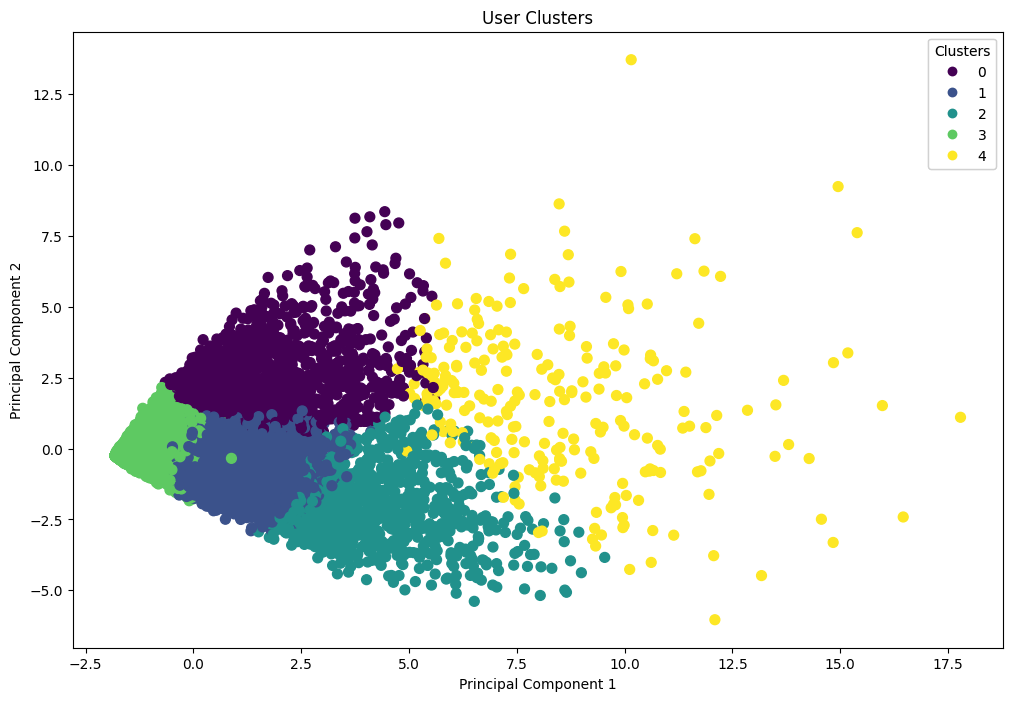

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
user_features_pca = pca.fit_transform(user_features_scaled)
anime_features_pca = pca.fit_transform(anime_features_scaled)

# Plotting function
def plot_clusters(features, labels, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.show()

# Plot user clusters
plot_clusters(user_features_pca, user_labels, 'User Clusters', 'Principal Component 1', 'Principal Component 2')



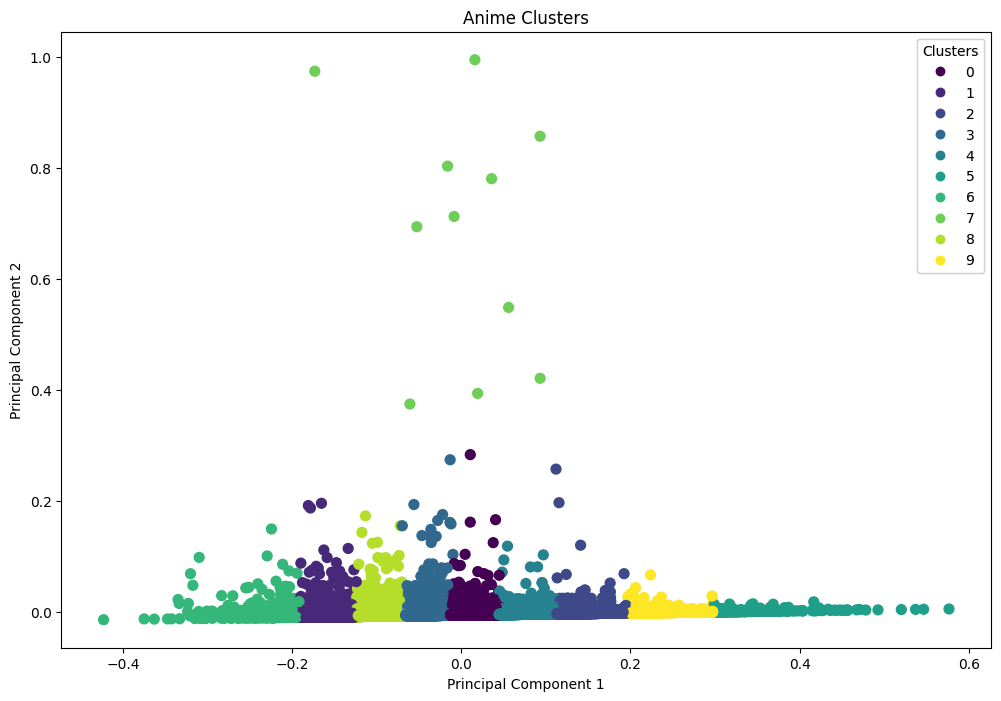

In [22]:
# Plot anime clusters
plot_clusters(anime_features_pca, anime_labels, 'Anime Clusters', 'Principal Component 1', 'Principal Component 2')

 **Heatmap of Similarity Scores**

A heatmap is a great way to visualize similarity scores, especially when dealing with large datasets. It shows the similarity matrix, where each cell represents the similarity score between two entities

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_heatmap(similarity_matrix, labels, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, xticklabels=labels, yticklabels=labels, cmap='viridis', annot=True, fmt='.2f')
    plt.title(title)
    plt.xlabel('Entity')
    plt.ylabel('Entity')
    plt.show()

In [ ]:
# Example: User similarity heatmap
user_similarity_matrix = cosine_similarity(user_features_scaled)
user_ids = train_df['user_id'].unique()
plot_similarity_heatmap(user_similarity_matrix, user_ids, 'User Similarity Heatmap')

In [1]:
# Example: Anime similarity heatmap
anime_similarity_matrix = cosine_similarity(anime_features_scaled)
anime_ids = anime_df['anime_id'].values
plot_similarity_heatmap(anime_similarity_matrix, anime_ids, 'Anime Similarity Heatmap')


In [ ]:
def get_similar_users(user_id, user_clusters, user_features_scaled, top_n=5):
    user_cluster = user_clusters[user_id - 1]
    similar_users = np.where(user_clusters == user_cluster)[0]
    similarity_scores = cosine_similarity(user_features_scaled[user_id - 1].reshape(1, -1), user_features_scaled[similar_users]).flatten()
    similar_user_indices = np.argsort(similarity_scores)[::-1][1:top_n + 1]
    return similar_users[similar_user_indices], similarity_scores[similar_user_indices]

# Example: Get top 5 similar users to user with ID 1
similar_users, similarities = get_similar_users(user_id=1, user_clusters=user_clusters, user_features_scaled=user_features_scaled)
print("Similar Users:", similar_users)
print("Similarity Scores:", similarities)
